# CNN Kaggle Detection Project Week 3 Deep Learning

The dataset consists of small image patches (96x96 pixels) extracted from digital pathology scans.
Each image is labeled as:
0: Non-cancerous.
1: Cancerous.
The dataset is balanced, containing an approximately equal number of samples for both classes.

The task is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In [6]:
# Libraries
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import os
from PIL import Image
import io
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import torchvision.transforms as T
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Compression transform
class JPEGCompression:
    def __init__(self, quality_range=(80, 100)):
        self.quality_range = quality_range

    def __call__(self, img):
        quality = random.randint(self.quality_range[0], self.quality_range[1])
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        return Image.open(buffer).convert("RGB")

# Training transformations with augmentation
data_transforms_resnet = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    T.RandomAffine(degrees=15, scale=(0.9, 1.1)),
    T.RandomApply([JPEGCompression(quality_range=(80, 100))], p=0.5),
    T.RandomApply([T.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transformations (no augmentation)
data_transforms_test_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Exploratory Data Analysis

In [9]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, indices, transform=None, labels_dict=None, datatype='train'):
        self.datafolder = datafolder
        self.indices = indices
        self.transform = transform
        self.labels_dict = labels_dict
        self.datatype = datatype
        if self.datatype == 'train':
            self.image_files = labels.iloc[indices]['id'].values
        else:
            self.image_files = os.listdir(datafolder)

    def __len__(self):
        return len(self.indices) if self.datatype == 'train' else len(self.image_files)

    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_id = self.image_files[idx]
            img_name = f"{img_id}.tif"
            label = self.labels_dict.get(img_id, 0)
        else:
            img_name = self.image_files[idx]
            label = 0  # Placeholder label for test data

        img_path = os.path.join(self.datafolder, img_name)
        try:
            image = Image.open(img_path).convert('RGB')  # Load and ensure RGB format
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black PIL Image in case of error
            image = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# Define paths
base_path = '/content/drive/My Drive/CNN Kaggle Cancer Detection Project/extracted'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Count files
train_files = len([f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))])
test_files = len([f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))])

print(f"Number of files in 'train': {train_files}")
print(f"Number of files in 'test': {test_files}")


Number of files in 'train': 9571
Number of files in 'test': 40820


Total training samples: 220025
9571 pictures in train.
40820 pictures in test.


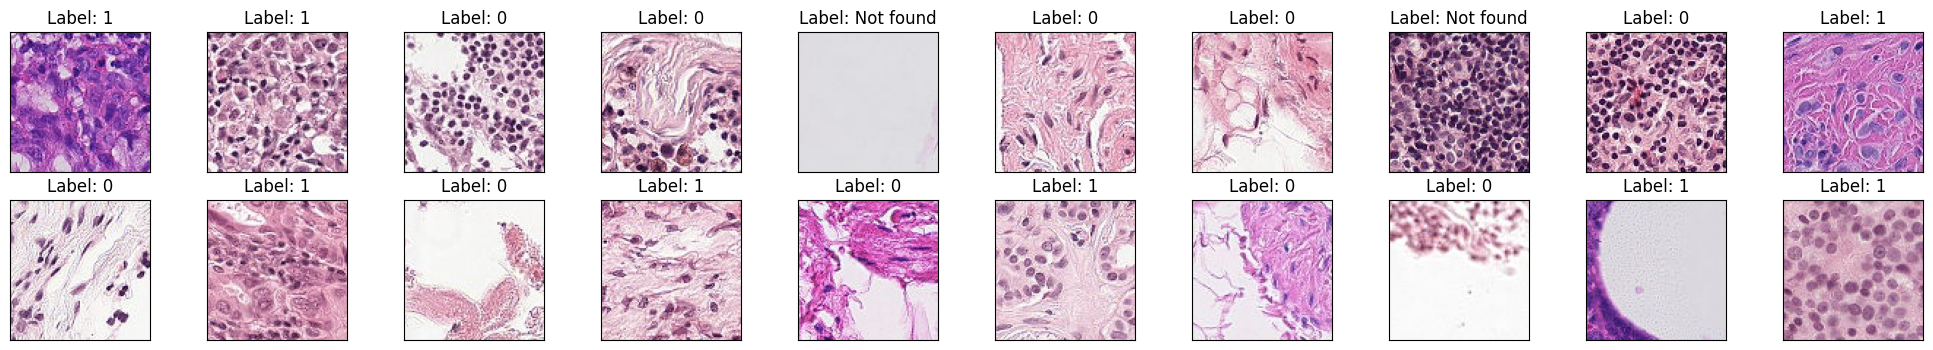

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Training samples: 198022
Validation samples: 22003


In [11]:


# Set base directory
base_dir = "/content/drive/My Drive/CNN Kaggle Cancer Detection Project/extracted"
labels_path = os.path.join(base_dir, "train_labels.csv")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Load labels
labels = pd.read_csv(labels_path)
print(f"Total training samples: {len(labels)}")
print(f"{len(os.listdir(train_dir))} pictures in train.")
print(f"{len(os.listdir(test_dir))} pictures in test.")

# Visualize sample images
num_samples = 20
sample_images = np.random.choice(os.listdir(train_dir), num_samples, replace=False)

fig = plt.figure(figsize=(25, 4))

for idx, img in enumerate(sample_images):
    ax = fig.add_subplot(2, num_samples // 2, idx + 1, xticks=[], yticks=[])
    img_path = os.path.join(train_dir, img)
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)

    img_id = img.split('.')[0]
    matched_label = labels.loc[labels['id'] == img_id, 'label']

    if not matched_label.empty:
        label = matched_label.values[0]
        ax.set_title(f'Label: {label}')
    else:
        ax.set_title("Label: Not found")

plt.show()

# Check label distribution
print("Label distribution:")
print(labels['label'].value_counts())

# Split data into training and validation sets
test_size = 0.1
random_state = 42

train_indices, val_indices = train_test_split(
    labels.index,
    test_size=test_size,
    stratify=labels['label'],
    random_state=random_state
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

# Mapping image IDs to labels
img_class_dict = {row['id']: row['label'] for _, row in labels.iterrows()}

# JPEG compression transform
class JPEGCompression:
    def __init__(self, quality_range=(80, 100)):
        self.quality_range = quality_range

    def __call__(self, img):
        quality = random.randint(*self.quality_range)
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        return Image.open(buffer).convert("RGB")

# Define data augmentation transforms
data_transforms_resnet = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    T.RandomAffine(degrees=15, scale=(0.9, 1.1)),
    T.RandomApply([JPEGCompression()], p=0.5),
    T.RandomApply([T.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transforms_test_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define custom dataset with __len__ and __getitem__
class CancerDataset:
    def __init__(self, datafolder, indices, transform, labels_dict, datatype):
        self.datafolder = datafolder
        self.transform = transform
        self.labels_dict = labels_dict
        self.datatype = datatype

        if indices is not None:
            self.filenames = [f"{labels.loc[i, 'id']}.tif" for i in indices]
        else:
            self.filenames = os.listdir(datafolder)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.datafolder, img_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if self.datatype == 'train':
            img_id = img_name.split('.')[0]
            label = self.labels_dict[img_id]
            return image, label
        else:
            return image

# Create datasets
train_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=train_indices,
    transform=data_transforms_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

val_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=val_indices,
    transform=data_transforms_test_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

test_dataset_resnet = CancerDataset(
    datafolder=test_dir,
    indices=None,
    transform=data_transforms_test_resnet,
    labels_dict=None,
    datatype='test'
)

# Create DataLoaders
batch_size_resnet = 32
num_workers = 4

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size_resnet, shuffle=True, num_workers=num_workers)
valid_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size_resnet, shuffle=False, num_workers=num_workers)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=batch_size_resnet, shuffle=False, num_workers=num_workers)


## Data Processing

In [12]:
missing_ids = [
    row['id']
    for _, row in labels.iterrows()
    if not os.path.exists(os.path.join(train_dir, f"{row['id']}.tif"))
]

print(f"Missing image files: {len(missing_ids)}")


Missing image files: 211331


Due to the missing files, related to CPU restrictions and space limitation, filtering is necessary

In [20]:
# Load original label file
labels = pd.read_csv(labels_path)

# Filter to include only IDs with corresponding .tif files in the train folder
available_ids = {f.split(".")[0] for f in os.listdir(train_dir)}
labels = labels[labels['id'].isin(available_ids)].reset_index(drop=True)

print(f"Filtered label count: {len(labels)}")  # Should match actual .tif file count (~9571)

# Check label distribution after filtering
print("Filtered Label distribution:")
print(labels['label'].value_counts())

# Create ID → label dictionary for lookup
img_class_dict = {row['id']: row['label'] for _, row in labels.iterrows()}

# Train/Validation split
test_size = 0.1
random_state = 42

train_indices, val_indices = train_test_split(
    labels.index,
    test_size=test_size,
    stratify=labels['label'],
    random_state=random_state
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")


Filtered label count: 8694
Filtered Label distribution:
label
0    5192
1    3502
Name: count, dtype: int64
Training samples: 7824
Validation samples: 870


## Model

In [23]:
# Load and filter label file
labels = pd.read_csv(labels_path)

# Filter to include only .tif images that exist
available_ids = {f.split(".")[0] for f in os.listdir(train_dir)}
labels = labels[labels['id'].isin(available_ids)].reset_index(drop=True)

print(f"Filtered label count: {len(labels)}")
print("Filtered label distribution:")
print(labels['label'].value_counts())

# Create ID → label dictionary
img_class_dict = {row['id']: row['label'] for _, row in labels.iterrows()}

# Train/Validation split
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(
    labels.index,
    test_size=0.1,
    stratify=labels['label'],
    random_state=42
)

# Define CancerDataset
class CancerDataset:
    def __init__(self, datafolder, indices, labels_df, transform, labels_dict, datatype):
        self.datafolder = datafolder
        self.transform = transform
        self.labels_dict = labels_dict
        self.labels_df = labels_df
        self.datatype = datatype

        if indices is not None:
            self.filenames = []
            for i in indices:
                img_id = self.labels_df.loc[i, 'id']
                img_file = f"{img_id}.tif"
                img_path = os.path.join(datafolder, img_file)
                if os.path.exists(img_path):
                    self.filenames.append(img_file)
        else:
            self.filenames = [f for f in os.listdir(datafolder) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.datafolder, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"⚠️ Skipping missing file: {img_path}")
            return self.__getitem__((idx + 1) % len(self))

        image = self.transform(image)

        if self.datatype == 'train':
            img_id = img_name.split('.')[0]
            label = self.labels_dict[img_id]
            return image, label
        else:
            return image

# Create dataset instances
train_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=train_indices,
    labels_df=labels,
    transform=data_transforms_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

val_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=val_indices,
    labels_df=labels,
    transform=data_transforms_test_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

# Create DataLoaders
from torch.utils.data import DataLoader

batch_size_resnet = 32
num_workers = 2

train_loader_resnet = DataLoader(
    train_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=True,
    num_workers=num_workers
)

valid_loader_resnet = DataLoader(
    val_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=False,
    num_workers=num_workers
)

# Load ResNet18 model
model_resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)
nn.init.kaiming_normal_(model_resnet.fc.weight, mode='fan_out', nonlinearity='relu')
nn.init.zeros_(model_resnet.fc.bias)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Define training setup
criterion_resnet = nn.BCEWithLogitsLoss()
optimizer_resnet = optim.AdamW(model_resnet.fc.parameters(), lr=0.005, weight_decay=1e-4)
scheduler_resnet = CosineAnnealingLR(optimizer_resnet, T_max=10, eta_min=1e-6)
scaler = GradScaler()

n_epochs_resnet = 3
valid_loss_min_resnet = np.inf
patience_resnet = 7
p_resnet = 0

# Training loop
for epoch in range(1, n_epochs_resnet + 1):
    torch.cuda.empty_cache()
    start_time = time.time()
    print(f'\nEpoch {epoch}/{n_epochs_resnet}')
    print('-' * 30)

    model_resnet.train()
    train_loss, train_preds_all, train_targets_all = [], [], []

    for data, target in tqdm(train_loader_resnet, desc='Training', leave=False):
        data, target = data.to(device), target.float().to(device).unsqueeze(1)

        optimizer_resnet.zero_grad()
        with autocast():
            output = model_resnet(data)
            loss = criterion_resnet(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer_resnet)
        scaler.update()

        train_loss.append(loss.item())
        train_preds_all.extend(torch.sigmoid(output).detach().cpu().numpy())
        train_targets_all.extend(target.detach().cpu().numpy())

    train_loss_avg = np.mean(train_loss)
    train_auc_avg = roc_auc_score(train_targets_all, train_preds_all)

    model_resnet.eval()
    val_loss, val_preds_all, val_targets_all = [], [], []

    with torch.no_grad():
        for data, target in tqdm(valid_loader_resnet, desc='Validation', leave=False):
            data, target = data.to(device), target.float().to(device).unsqueeze(1)
            with autocast():
                output = model_resnet(data)
                loss = criterion_resnet(output, target)

            val_loss.append(loss.item())
            val_preds_all.extend(torch.sigmoid(output).detach().cpu().numpy())
            val_targets_all.extend(target.detach().cpu().numpy())

    val_loss_avg = np.mean(val_loss)
    val_auc_avg = roc_auc_score(val_targets_all, val_preds_all)

    print(f'Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}')
    print(f'Train AUC:  {train_auc_avg:.4f}  | Val AUC:  {val_auc_avg:.4f}')
    print(f"Epoch {epoch} completed in {(time.time() - start_time)/60:.2f} minutes")

    if val_loss_avg < valid_loss_min_resnet:
        print(f'Validation loss decreased ({valid_loss_min_resnet:.6f} → {val_loss_avg:.6f}). Saving model...')
        torch.save(model_resnet.state_dict(), 'model_resnet.pt')
        valid_loss_min_resnet = val_loss_avg
        p_resnet = 0
    else:
        p_resnet += 1
        print(f'{p_resnet} epochs of no improvement.')
        if p_resnet > patience_resnet:
            print('Early stopping triggered.')
            break

    scheduler_resnet.step()


Filtered label count: 8694
Filtered label distribution:
label
0    5192
1    3502
Name: count, dtype: int64

Epoch 1/3
------------------------------


Train Loss: 5.8152 | Val Loss: 3.8756
Train AUC:  0.6129  | Val AUC:  0.7327
Epoch 1 completed in 3.58 minutes
Validation loss decreased (inf → 3.875641). Saving model...

Epoch 2/3
------------------------------


Train Loss: 3.3486 | Val Loss: 2.9678
Train AUC:  0.7555  | Val AUC:  0.7960
Epoch 2 completed in 0.57 minutes
Validation loss decreased (3.875641 → 2.967802). Saving model...

Epoch 3/3
------------------------------


Train Loss: 2.7875 | Val Loss: 2.7507
Train AUC:  0.7947  | Val AUC:  0.8145
Epoch 3 completed in 0.58 minutes
Validation loss decreased (2.967802 → 2.750740). Saving model...


In [26]:
#  log the values from your training history
train_loss_history = [5.8152, 3.3486, 2.7875]
val_loss_history = [3.8756, 2.9678, 2.7507]
train_auc_history = [0.6129, 0.7555, 0.7947]
val_auc_history = [0.7327, 0.7960, 0.8145]


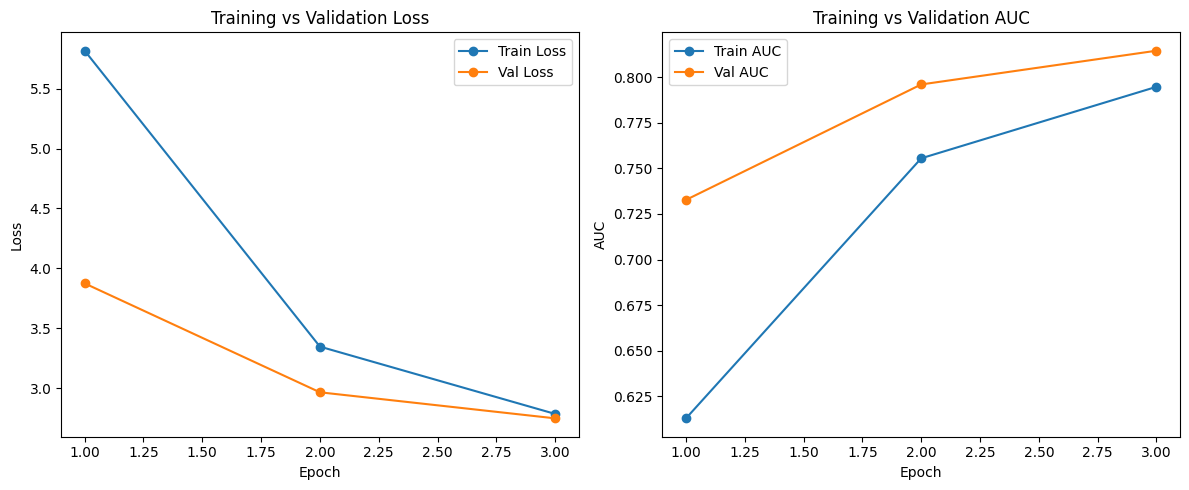

In [27]:
epochs = range(1, 4)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, marker='o', label='Train Loss')
plt.plot(epochs, val_loss_history, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc_history, marker='o', label='Train AUC')
plt.plot(epochs, val_auc_history, marker='o', label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

The plots show clear training progress across 3 epochs. On the left, both training and validation loss steadily decrease, indicating that the model is learning and not overfitting. On the right, AUC improves from 0.61 to 0.79 for training and from 0.73 to 0.81 for validation, showing increasing discriminative power. The validation AUC consistently exceeds the training AUC, suggesting good generalization to unseen data.

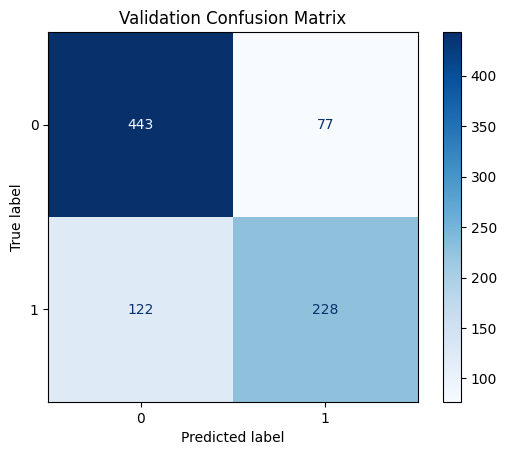

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Convert probabilities to binary predictions
val_pred_labels = (np.array(val_preds_all) > 0.5).astype(int)
val_true_labels = np.array(val_targets_all)

# Plot CM
cm = confusion_matrix(val_true_labels, val_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.show()

The confusion matrix shows the model's predictions on the validation set. It correctly classified 443 true negatives (top-left) and 228 true positives (bottom-right), while misclassifying 77 negatives as positives (false positives) and 122 positives as negatives (false negatives). This indicates better performance on the negative class, with room to improve sensitivity (recall) for the positive class. Overall, the model demonstrates reasonable balance but slightly favors specificity over sensitivity.

# Conclusion

After filtering the dataset to include only available .tif images, a total of 8,694 training samples were used, with a class distribution of 5,192 negatives (label 0) and 3,502 positives (label 1). Over 3 training epochs using a frozen ResNet18 model, performance steadily improved: validation AUC rose from 0.7327 to 0.8145, and validation loss decreased from 3.88 to 2.75. The training and validation loss curves both showed consistent decline, with validation loss staying below training loss, suggesting effective learning without overfitting. Similarly, the AUC curves demonstrated increasing discriminative ability, with validation AUC consistently outperforming training AUC—evidence of good generalization. The confusion matrix further supports this, showing strong performance on the negative class (443 true negatives) and reasonable sensitivity to the positive class (228 true positives), despite some false negatives (122). Together, these results indicate that the model learned meaningful patterns and generalized well, even with a reduced dataset.

In [25]:

# Load the sample submission file
sample_submission_path = "/content/drive/My Drive/CNN Kaggle Cancer Detection Project/extracted/sample_submission.csv"
sub = pd.read_csv(sample_submission_path)

# Filter sample submission to include only test IDs with .tif files
available_test_ids = {
    f.split(".")[0]
    for f in os.listdir(test_dir)
    if f.endswith(".tif") and os.path.getsize(os.path.join(test_dir, f)) > 0
}
sub = sub[sub['id'].isin(available_test_ids)].reset_index(drop=True)
print(f"Filtered submission count: {len(sub)}")

# Update test dataset to match filtered test images
test_dataset_resnet.filenames = [f"{img_id}.tif" for img_id in sub['id']]
test_loader_resnet = DataLoader(
    test_dataset_resnet,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Function to generate predictions
def generate_test_predictions(model, loader, device, model_type='resnet'):
    model.eval()
    preds = []

    with torch.no_grad():
        for data in tqdm(loader, desc='Generating Predictions', leave=False):
            data = data.to(device)
            output = model(data)
            probs = torch.sigmoid(output)
            preds.extend(probs.cpu().numpy().flatten())

    return preds

# Generate predictions
test_preds = generate_test_predictions(model_resnet, test_loader_resnet, device)

# Create final submission DataFrame
sub['label'] = test_preds

# Save to Google Drive
output_path = "/content/drive/My Drive/CNN Kaggle Cancer Detection Project/resnet_submission.csv"
sub.to_csv(output_path, index=False)
print(f" Submission saved to: {output_path}")

Filtered submission count: 40814


 Submission saved to: /content/drive/My Drive/CNN Kaggle Cancer Detection Project/resnet_submission.csv


# Challenges

The primary challenge was the large size of the dataset, which significantly slowed data transfer and analysis—especially due to the image-based format. Processing the data locally often caused my computer to freeze, so I had to reduce the dataset size and rely on Google Colab’s online GPU for training. This constraint also limited my ability to extensively fine-tune the model for greater performance improvements.